In [21]:
import sys, os, tqdm
import scout
import numpy as np
import scanpy as sc
import pandas as pd
import scvi

import core.deconV as dV

import chart_studio.plotly as py
import plotly.graph_objects as go

In [22]:
dV.params = {
    "cell_type_key": "cellType",
    "selected_ct": ["0", "1", "2"],
    "indir": "../../data/GSE136148/",
    "ignore_others": True,
    "n_top_genes": -1,
}

In [23]:
sadata = dV.read_data(os.path.join(dV.params["indir"], "sc.tsv"))

pheno_df = pd.read_csv(os.path.join(dV.params["indir"], "pdata.tsv"), sep="\t", index_col=0)
pheno_df.index.name = None
sadata.obs = pd.concat([sadata.obs, pheno_df], axis=1)
assert dV.params["cell_type_key"] in sadata.obs.columns, f"{dV.params['cell_type_key']} not in obs columns"
sadata.obs[dV.params["cell_type_key"]] = sadata.obs[dV.params["cell_type_key"]].astype(str)

sadata

AnnData object with n_obs × n_vars = 3022 × 33694
    obs: 'cellType'

In [ ]:
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)

In [ ]:
sadata.write_h5ad("preprocessed_bulk.h5ad")

In [24]:
badata = dV.read_data(os.path.join(dV.params["indir"], "bulk.tsv"), is_bulk=True)
badata

/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1 × 58387

In [25]:
sadata, badata = dV.preprocess(sadata, badata)
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

scRNA-seq data - cells: 2993, genes: 18597
bulk RNA-seq data - samples: 1, genes: 18597


In [26]:
sadata

AnnData object with n_obs × n_vars = 2993 × 18597
    obs: 'cellType', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'ncounts', 'centered', 'logcentered'

In [17]:
sc.tl.pca(sadata)
sc.pp.neighbors(sadata, random_state=0)
sc.tl.umap(sadata, min_dist=0.3)
sc.tl.leiden(sadata, random_state=0, resolution=0.1)

/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


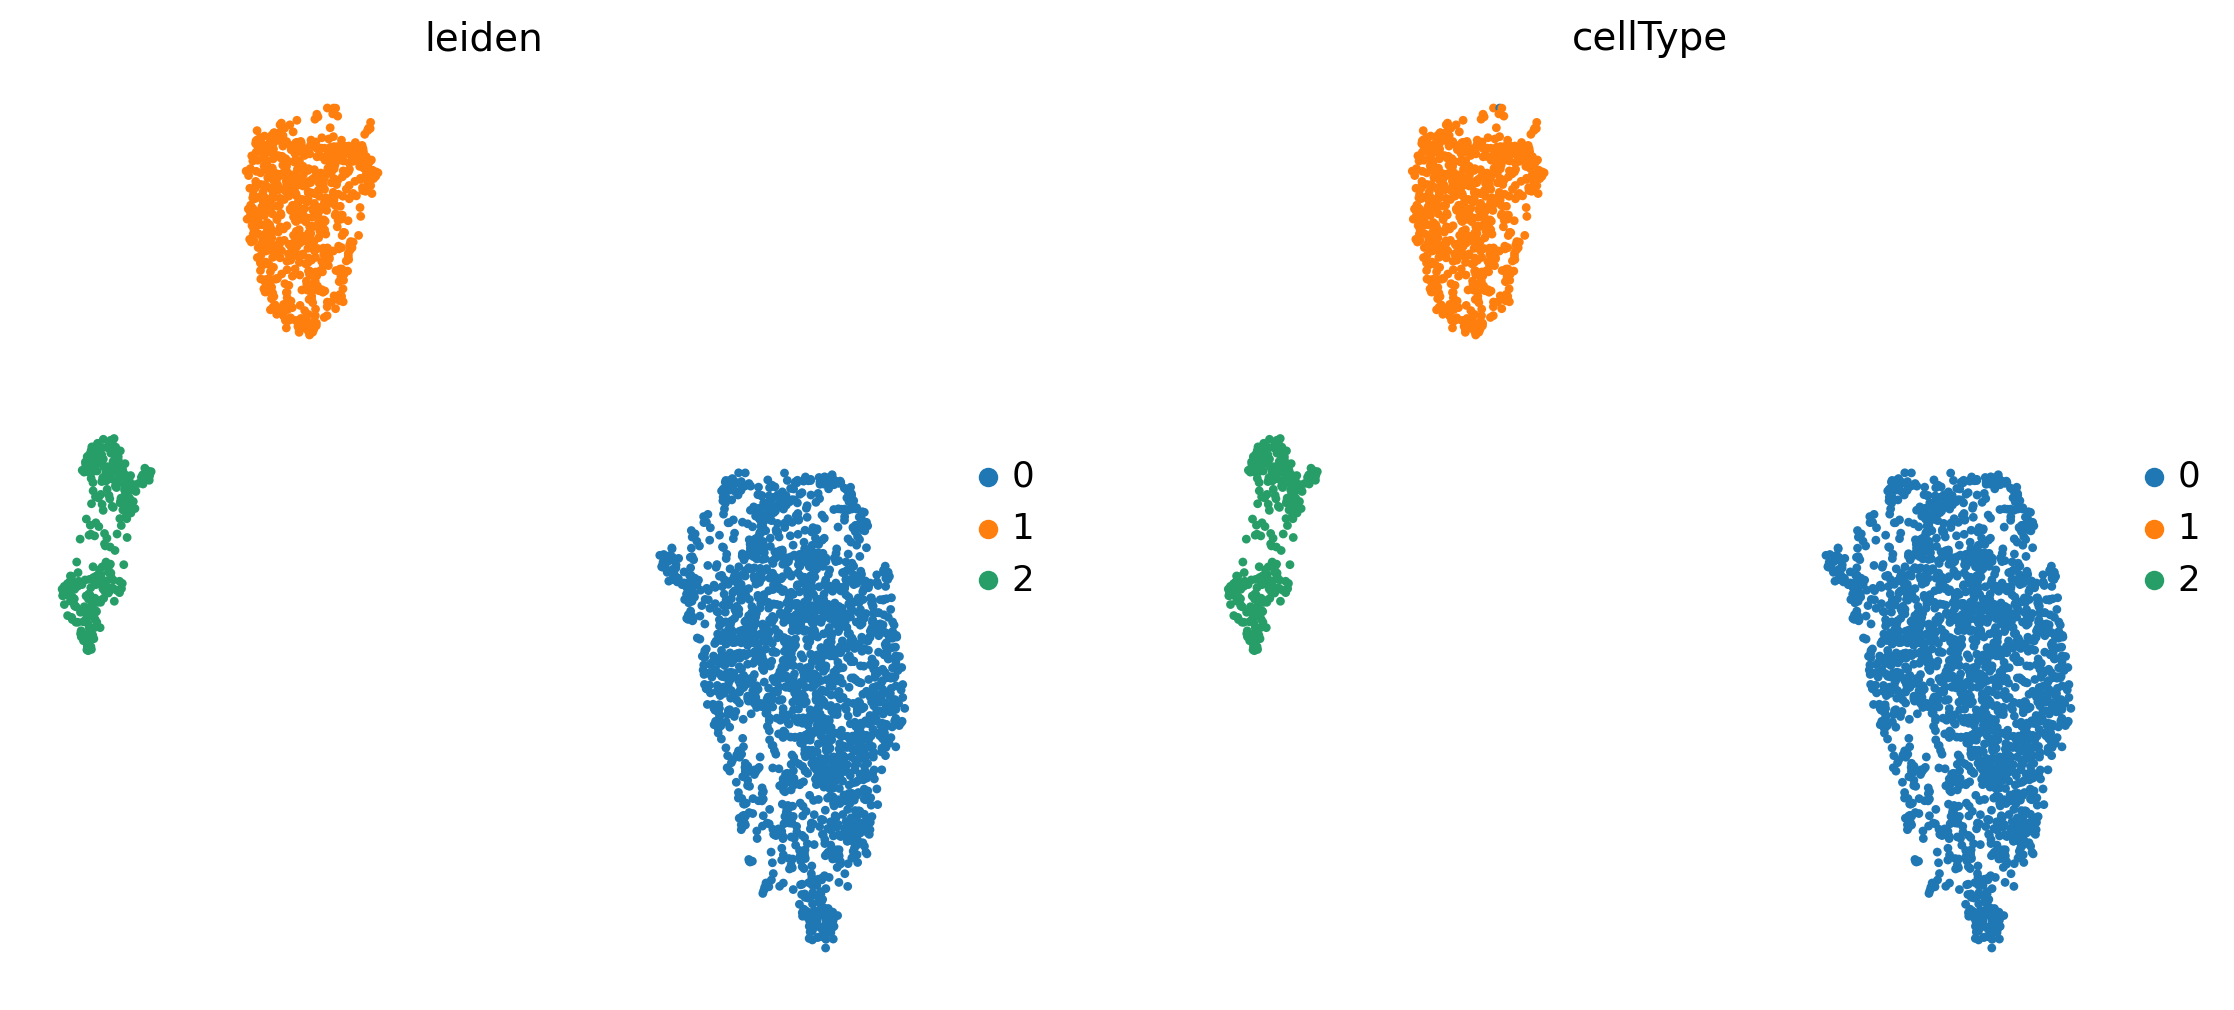

In [18]:
sc.settings.set_figure_params(figsize=(6,6), dpi=100, facecolor='white')
sc.pl.umap(sadata,  color=["leiden", dV.params["cell_type_key"]], ncols=2, frameon=False)

In [55]:
scvi.model.SCVI.setup_anndata(sadata, layer="counts")
vae = scvi.model.SCVI(sadata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [04:08<00:00,  1.61it/s, loss=1.36e+03, v_num=1]


In [60]:
sadata.obsm["scvi"] = vae.get_latent_representation()

In [63]:
sc.pp.neighbors(sadata, use_rep="scvi")
sc.tl.leiden(sadata, random_state=0, resolution=0.1)
sc.tl.umap(sadata, min_dist=0.3)

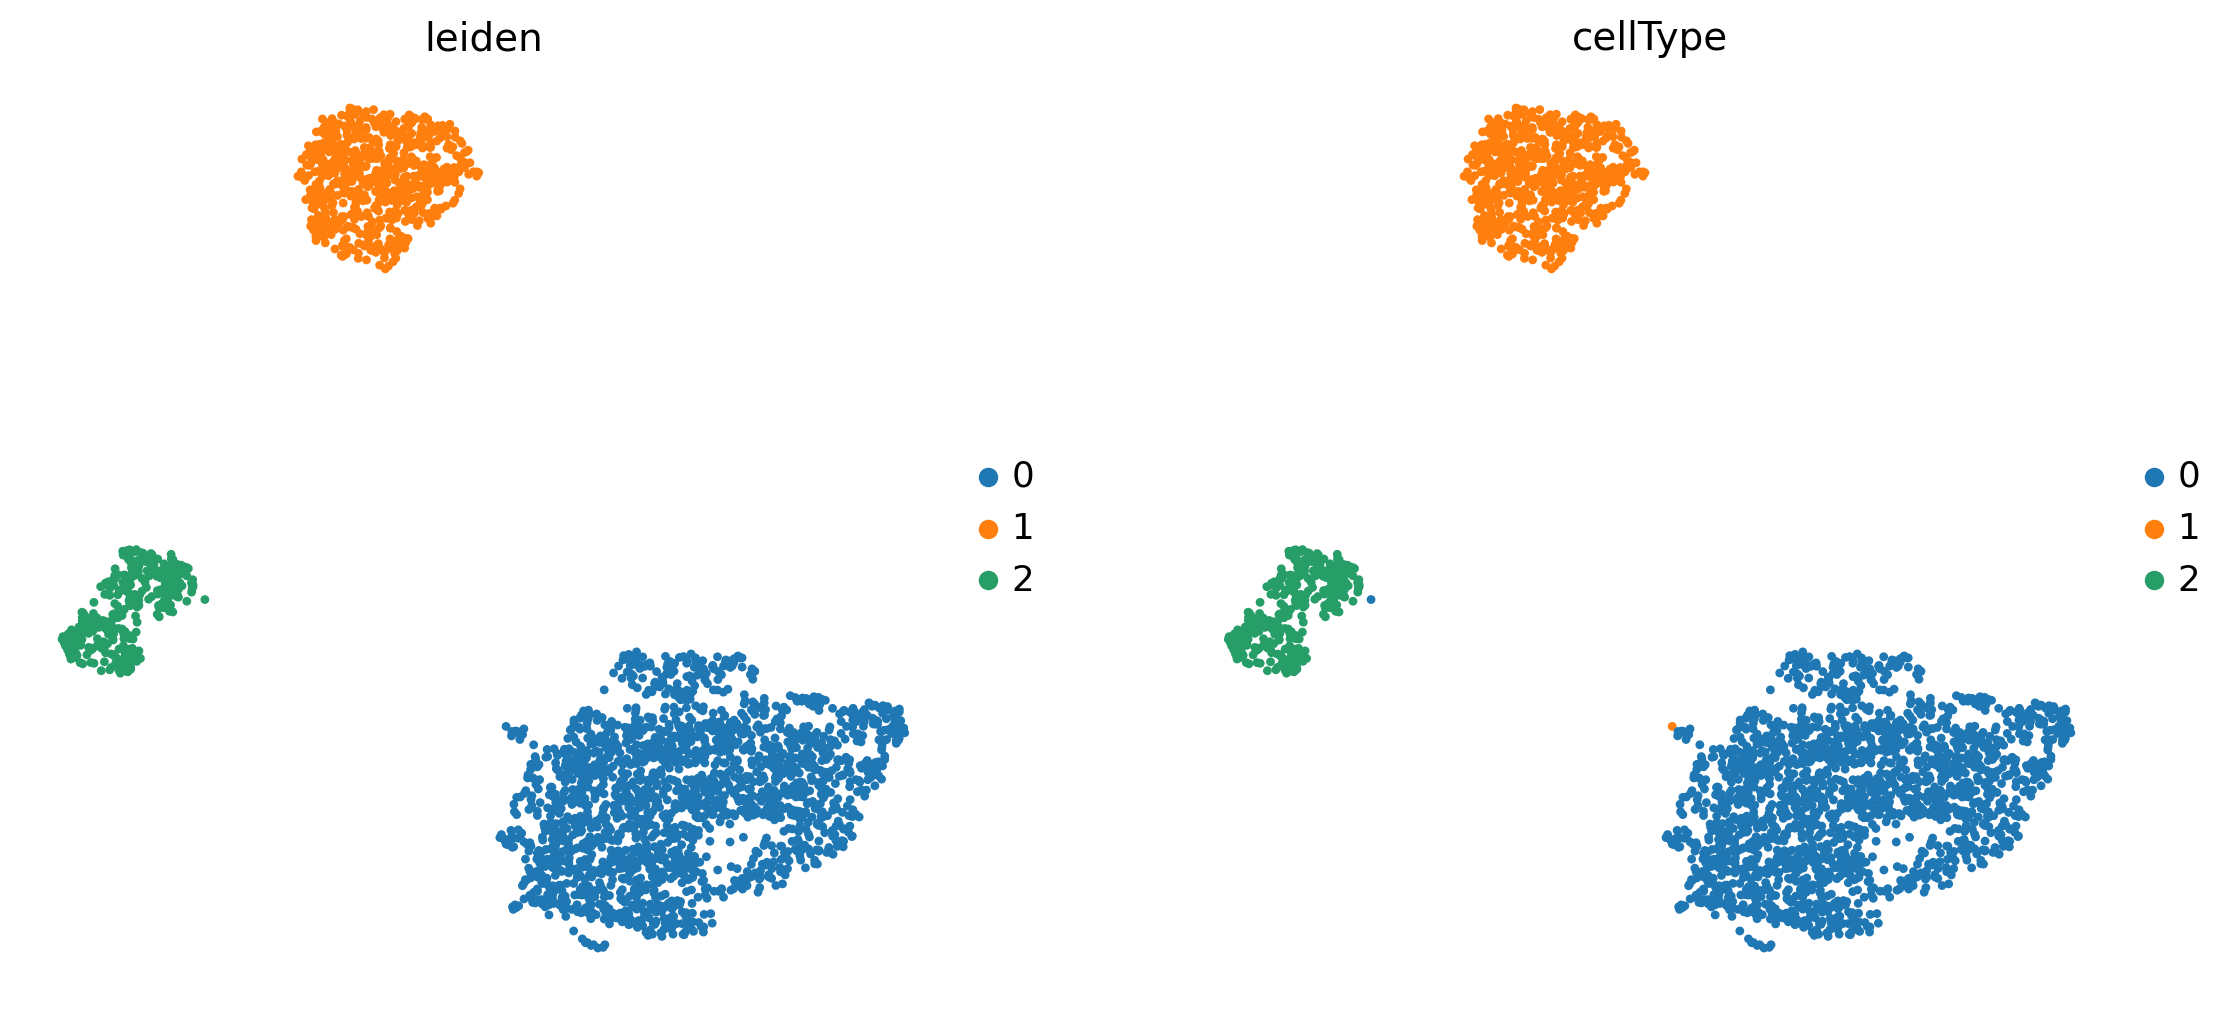

In [64]:
sc.pl.umap(sadata,  color=["leiden", dV.params["cell_type_key"]], ncols=2, frameon=False)

In [68]:
de = vae.differential_expression(sadata, groupby="leiden")

DE...: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


In [69]:
de.columns

Index(['proba_de', 'proba_not_de', 'bayes_factor', 'scale1', 'scale2',
       'pseudocounts', 'delta', 'lfc_mean', 'lfc_median', 'lfc_std', 'lfc_min',
       'lfc_max', 'raw_mean1', 'raw_mean2', 'non_zeros_proportion1',
       'non_zeros_proportion2', 'raw_normalized_mean1', 'raw_normalized_mean2',
       'is_de_fdr_0.05', 'comparison', 'group1', 'group2'],
      dtype='object')

In [75]:
de["group1"]

LINC01133    0
RAB32        0
FADS1        0
VOPP1        0
EIF4G3       0
            ..
GNAS         2
TMSB10       2
SERF2        2
ACTG1        2
ARPC2        2
Name: group1, Length: 15000, dtype: object